File to train on the toy_df.csv (that came from the 001_Forbes Dataset)

In [13]:
import os
import ast
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import random
import pandas as pd
from transformers import TapasConfig, TapasForQuestionAnswering, TapasTokenizer, AdamW, get_linear_schedule_with_warmup
warnings.filterwarnings("ignore")

In [14]:
# load in tokenizer
tokenizer = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")

In [15]:
# Function to convert the string representation to a list of tuples
def parse_answer_coords(coords_str):
    try:
        # Safely evaluate the string to a Python object
        coords = ast.literal_eval(coords_str)
        
        # Ensure the result is a list of tuples with integers
        if isinstance(coords, list) and all(
            isinstance(coord, (tuple, list)) and len(coord) == 2 and all(isinstance(x, int) for x in coord)
            for coord in coords
        ):
            return [tuple(coord) for coord in coords]  # Convert lists to tuples if needed
        else:
            raise ValueError(f"Invalid format for answer_coords: {coords_str}")
    except (ValueError, SyntaxError) as e:
        raise ValueError(f"Error parsing answer_coords: {coords_str}. Details: {e}")

In [16]:
# class to tokenizer dataset
class TableDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = self.process_answer_coords_column(data)
        self.tokenizer = tokenizer
        self.table_csv_path = 'data/'

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        table = pd.read_csv(self.table_csv_path + item.dataset).astype(
            str
        ) 

        encoding = self.tokenizer(
            table=table,
            queries=item.question,
            answer_coordinates=item.answer_coords,
            answer_text=item.sample_answer,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        # add the float_answer which is also required for weak supervision (WTQ)
        encoding["float_answer"] = torch.tensor(item.float_answer)
        return encoding

    def __len__(self):
        return len(self.data)
    
    # change answer_coords from strings
    def process_answer_coords_column(self, data, column_name="answer_coords"):
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' does not exist in the dataset.")

        def parse_answer_coords(coords_str):
            try:
                coords = ast.literal_eval(coords_str)
                if isinstance(coords, list) and all(
                    isinstance(coord, (tuple, list)) and len(coord) == 2 and all(isinstance(x, int) for x in coord)
                    for coord in coords
                ):
                    return [tuple(coord) for coord in coords]
                else:
                    raise ValueError(f"Invalid format for answer_coords: {coords_str}")
            except (ValueError, SyntaxError) as e:
                raise ValueError(f"Error parsing answer_coords: {coords_str}. Details: {e}")
        data[column_name] = data[column_name].apply(parse_answer_coords)
        return data

In [17]:
# load in toy_df, tokenize and place in dataloader
csv_path = 'data/toy_df.csv'
df = pd.read_csv(csv_path) # Model 1 style annotation

csv_path_v2 =  'data/toy_df_v2.csv' 
df_v2 = pd.read_csv(csv_path_v2) # Model 2 style annotation

csv_path_altered = 'data/altered.csv' # Model 1 style annotation with altered questions
df_alt =  pd.read_csv(csv_path_altered)

datasets = list(set(df['dataset'])) # get each dataset name
train_datasets = datasets[:len(datasets) - 2] # datasets to be used for train
dev_datasets = datasets[len(datasets) - 2:] # datasets to be used for dev

train_df = df[df['dataset'].isin(train_datasets)] 
train_df_v2 = df_v2[df_v2['dataset'].isin(train_datasets)]
train_alt = df_alt[df_alt['dataset'].isin(train_datasets)] # altered questions

dev_df = df[df['dataset'].isin(dev_datasets)]
dev_alt = df_alt[df_alt['dataset'].isin(dev_datasets)]

# load train dataloader
train_dataset = TableDataset(train_df, tokenizer)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

# load train_v2 dataloader
train_dataset_v2 = TableDataset(train_df_v2, tokenizer)
train_dataloader_v2 = torch.utils.data.DataLoader(train_dataset_v2, batch_size=8)

# load altered dataloader 
train_dataset_alt = TableDataset(train_alt, tokenizer)
train_dataloader_alt = torch.utils.data.DataLoader(train_dataset_alt, batch_size=8)

# load dev dataloader
dev_dataset = TableDataset(dev_df, tokenizer)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=8)

# load dev alt
dev_dataset_alt = TableDataset(dev_alt, tokenizer)
dev_dataloader_alt =  torch.utils.data.DataLoader(dev_dataset_alt, batch_size=8)

# get test datasets
test_data = pd.read_csv('data/test_real.csv')
test_alt_data = pd.read_csv('data/test_alt_real.csv')
test_dfs = list(set(test_data['dataset']))

In [18]:
# load in WTQ model (from TAPAS documentation)
config = TapasConfig(
    num_aggregation_labels=4,
    use_answer_as_supervision=True,
    answer_loss_cutoff=0.664694,
    cell_selection_preference=0.207951,
    huber_loss_delta=0.121194,
    init_cell_selection_weights_to_zero=True,
    select_one_column=True,
    allow_empty_column_selection=False,
    temperature=0.0352513,
)

model_finetune = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq", config=config) # finetune
optimizer = AdamW(model_finetune.parameters(), lr=1e-5)

In [17]:
def train_model(
    model, 
    train_dataloader, 
    dev_dataloader, 
    optimizer, 
    device, 
    epochs, 
    save_path, 
    description="Training Parameters Description"
):
    
    # Create scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,  # Optional warm-up period
        num_training_steps=total_steps
    )
    
    best_dev_loss = float('inf')
    model.to(device)
    
    save_path = 'models/' + save_path
    train_losses = [] 
    dev_losses = []    
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        epoch_train_loss = 0

        # Training loop
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_dataloader)
        train_losses.append(epoch_train_loss)
        
        
        # Evaluate on dev set
        epoch_dev_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(dev_dataloader, desc="Validation"):
                inputs = {key: value.to(device) for key, value in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                epoch_dev_loss += loss.item()
        epoch_dev_loss /= len(dev_dataloader)
        dev_losses.append(epoch_dev_loss)
        
        print(f"Training loss for epoch {epoch + 1}: {epoch_train_loss:.4f}")
        print(f"Validation loss for epoch {epoch + 1}: {epoch_dev_loss:.4f}")
        
    
    # Save final model
    model.save_pretrained(save_path)
    print(f"fine-tuned model saved to {save_path}")
    
    # Plot losses ans save
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), dev_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot with description in model directory
    plt.savefig(f"{save_path}/training_loss_plot.png")
    print(f"Loss plot saved")
    
    # Save training description
    with open(f"{save_path}/training_description.txt", "w") as desc_file:
        desc_file.write(description)
        desc_file.write(f"\nEpochs: {epochs}")
        desc_file.write(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
        desc_file.write(f"\nFinal Validation Loss: {dev_losses[-1]:.4f}")
    
    print('Done Training')
    return model

Epoch 1/15


Validation: 100%|█████████████████████████████████| 2/2 [00:09<00:00,  4.96s/it]


Training loss for epoch 1: 1.8435
Validation loss for epoch 1: 1.2506
Epoch 2/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.11s/it]


Training loss for epoch 2: 0.9654
Validation loss for epoch 2: 0.9450
Epoch 3/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.16s/it]


Training loss for epoch 3: 0.5360
Validation loss for epoch 3: 0.7922
Epoch 4/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]


Training loss for epoch 4: 0.4753
Validation loss for epoch 4: 0.7425
Epoch 5/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.36s/it]


Training loss for epoch 5: 0.4994
Validation loss for epoch 5: 0.7557
Epoch 6/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.45s/it]


Training loss for epoch 6: 0.4585
Validation loss for epoch 6: 0.7569
Epoch 7/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.49s/it]


Training loss for epoch 7: 0.4577
Validation loss for epoch 7: 0.7756
Epoch 8/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]


Training loss for epoch 8: 0.4452
Validation loss for epoch 8: 0.7832
Epoch 9/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.45s/it]


Training loss for epoch 9: 0.4106
Validation loss for epoch 9: 0.8184
Epoch 10/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.14s/it]


Training loss for epoch 10: 0.5306
Validation loss for epoch 10: 0.8808
Epoch 11/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]


Training loss for epoch 11: 0.4657
Validation loss for epoch 11: 0.8687
Epoch 12/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.03s/it]


Training loss for epoch 12: 0.5137
Validation loss for epoch 12: 0.8815
Epoch 13/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]


Training loss for epoch 13: 0.4348
Validation loss for epoch 13: 0.8288
Epoch 14/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.35s/it]


Training loss for epoch 14: 0.3984
Validation loss for epoch 14: 0.8393
Epoch 15/15


Validation: 100%|█████████████████████████████████| 2/2 [00:10<00:00,  5.10s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'temperature': 0.0352513}


Training loss for epoch 15: 0.4035
Validation loss for epoch 15: 0.8457
fine-tuned model saved to models/wtq_loss_display
Loss plot saved
Done Training


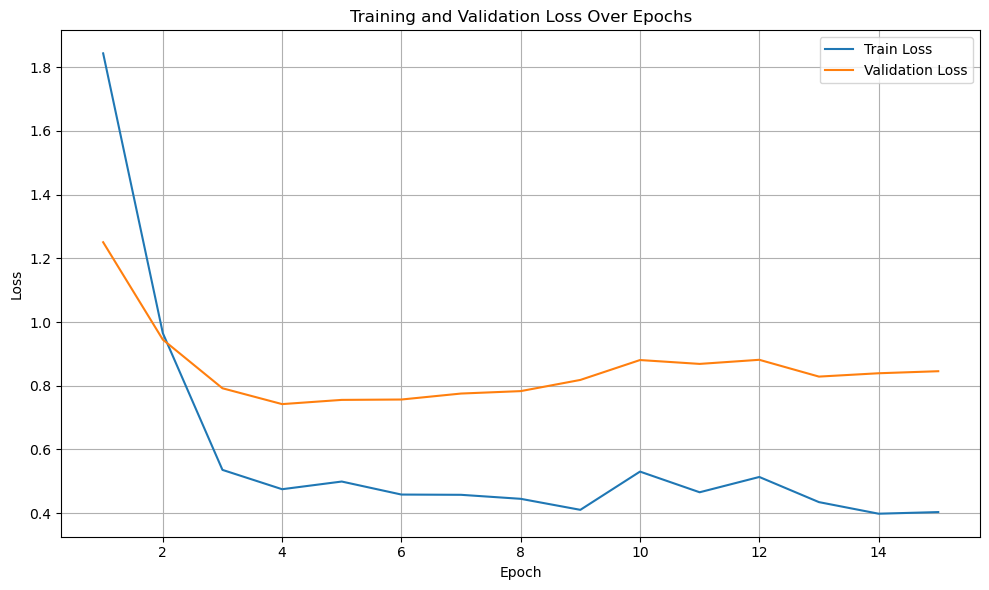

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
description = 'using altered.csv (altered off of toy_df.csv), kept learning rate to 1e-5, added a scheduler, 5 epochs'

# Finetune model
model_finetune = train_model(
    model=model_finetune,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    device=device,
    epochs=15,
    save_path="wtq_loss_display",
    description = description
)

In [12]:
# Inference
def inference(test_data, test_dfs, model, model_name, data_name):
    num_none = 0
    num_agg = 0
    num_correct = 0
    num_correct_none = 0
    num_correct_agg = 0
    total_questions = 0
    num_number = 0
    num_number_correct = 0
    num_category = 0
    num_category_correct = 0
    
    model.eval()
    
    with torch.no_grad():
        for file in test_dfs:
            table = pd.read_csv(f'data/{file}').astype(str)
            df = test_data[test_data['dataset'] == file]
            queries = list(df['question'])
            inputs = tokenizer(
                table = table,
                queries = queries,
                padding="max_length",
                return_tensors="pt",
                truncation = True
            )

            outputs = model(**inputs)
            predicted_answer_coordinates, predicted_aggregation_indices = tokenizer.convert_logits_to_predictions(
                inputs, outputs.logits.detach(), outputs.logits_aggregation.detach()
            )

            # print results:
            id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3: "COUNT"}
            aggregation_predictions_string = [id2aggregation[x] for x in predicted_aggregation_indices]

            answers = []
            for coordinates in predicted_answer_coordinates:
                if len(coordinates) == 1:
                    # only a single cell:
                    answers.append(table.iat[coordinates[0]])
                else:
                    # multiple cells
                    cell_values = []
                    for coordinate in coordinates:
                        cell_values.append(table.iat[coordinate])
                    answers.append(", ".join(cell_values))

            i = 0
            real_answers = list(df['sample_answer'])
            answer_type = list(df['type'])
            for query, answer, predicted_agg in zip(queries, answers, aggregation_predictions_string):
                total_questions += 1 
                print(query)

                print('Indeded type: ', answer_type[i])
                if answer_type[i] == 'number':
                    num_number += 1
                else:
                    num_category += 1

                if predicted_agg == "NONE":
                    print("     Predicted answer: " + answer)
                    print("     Real answer: ", real_answers[i])
                    if str(answer) == str(real_answers[i]):
                        print('          CORRECT!')
                        num_correct += 1
                        num_correct_none += 1
                        if answer_type[i] == 'number':
                            num_number_correct += 1
                        else:
                            num_category_correct += 1

                    i += 1
                    num_none += 1

                else:
                    print("     Predicted Cells: " + predicted_agg + " > " + answer)
                    if predicted_agg == 'COUNT':
                        count = answer.split(',')
                        answer = len(list(set(count)))
                        print('     Predicted Count: ', answer)
                        if answer % 1 == 0:
                            answer = int(answer)

                    if predicted_agg == 'AVERAGE':
                        total = 0
                        a = answer.split(',')
                        try:
                            a = [float(elem) for elem in a]
                        except:
                            print('     Predicted Average: Error')
                            answer = None
                            i += 1
                            print("     Real answer: ", str(real_answers[i]))
                            num_agg += 1
                            continue
                        num = len(a)
                        answer = 0
                        for elem in a:
                            answer += (elem/num)  
                        print('     Predicted Average:', answer)
                        if answer % 1 == 0:
                            answer = int(answer)
                            
                    if predicted_agg == 'SUM':
                        s = answer.split(',')
                        try:
                            s = [float(elem) for elem in a]
                        except:
                            print('     Predicted Average: Error')
                            answer = None
                            i += 1
                            print("     Real answer: ", str(real_answers[i]))
                            num_agg += 1
                            continue
                        answer = 0
                        for elem in s:
                            answer += elem
                        print('     Predicted Sum:', answer)
                        if answer % 1 == 0:
                            answer = int(answer)

                    print("     Real answer: ", str(real_answers[i]))
                    if str(answer) == str(real_answers[i]):
                            print('          CORRECT!')
                            num_correct += 1
                            num_correct_agg += 1
                            if answer_type[i] == 'number':
                                num_number_correct += 1
                            else:
                                num_category_correct += 1
                            
                    i += 1
                    num_agg += 1

        print("")
        print('Number of Questions: ', total_questions)
        print('Overall Accuracy: ', num_correct/total_questions)
        print('Number Accuracy: ', num_number_correct/num_number)
        print('Category Accuracy: ', num_category_correct/num_category)
        try:
            print('NONE Accuracy:', num_correct_none/num_none)
        except:
            print('***** No questions with predicted Aggregation Tag NONE ***** ')
        try:
            print('Agg Accuracy:', num_correct_agg/num_agg)
        except:
            print('***** No questions with predicted Aggregation Tag SUM, AVERAGE, or COUNT ***** ')
        print("")
        print("")
        
        # not saving the NONE and AGG accuracy to final stat report
        stats = {
            'model' : model_name,
            'test_data' : data_name,
            'total_questions' : total_questions,
            'overall_accuracy' : num_correct/total_questions,
            'number_accuracy' : num_number_correct/num_number,
            'category_accuracy' : num_category_correct/num_category
        }
        
        return stats

In [23]:
# Evaluation wtq
evaluations = []

model_name = "google/tapas-base-finetuned-wtq"
tokenizer = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")
wtq = TapasForQuestionAnswering.from_pretrained(model_name)
evaluations.append(inference(test_data, test_dfs, wtq, model_name, 'test_real.csv'))
evaluations.append(inference(test_alt_data, test_dfs, wtq, model_name, 'test_real_alt.csv'))

How many respondents in the survey are eligible to vote?
Indeded type:  number
     Predicted Cells: COUNT > 25-34, 25-34, 55-64, 65+, 65+, 55-64, 25-34, 35-44, 25-34, 45-54, 35-44, 35-44, 25-34, 18-24, 55-64, 45-54, 65+, 18-24, 18-24, 55-64
     Predicted Count:  7
     Real answer:  11
What is the most frequent age group among the respondents?
Indeded type:  category
     Predicted answer: Some college, no degree
     Real answer:  25-34
Who is the preferred choice among the respondents for the upcoming election?
Indeded type:  category
     Predicted answer: Donald Trump (Republican)
     Real answer:  Joe Biden (Democrat)
What is the most commonly achieved educational level among the respondents?
Indeded type:  category
     Predicted answer: Some college, no degree
     Real answer:  High school graduate (includes equivalency)
Which geographical division has the greatest representation among the respondents? If there is a tie solve it by reverse alphabetical order. 
Indeded type: 

What is the highest loan amount in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 8613
     Predicted Average: 8613.0
     Real answer:  8613
          CORRECT!
How many borrowers have more than 1 existing loan?
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7253, 3643, 3368, 2124, 1098, 585
     Predicted Count:  7
     Real answer:  7
          CORRECT!
What is the longest loan duration in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 7297
     Predicted Average: 7297.0
     Real answer:  60
How many borrowers are older than 50?
Indeded type:  number
     Predicted Cells: COUNT > 7297, 7253, 6288, 4380, 4153, 3965, 3577, 2384, 2325, 2116
     Predicted Count:  10
     Real answer:  2
What is the most common purpose of loans?
Indeded type:  category
     Predicted answer: Used Car
     Real answer:  Radio/TV
What is the most common job category for borrowers?
Indeded type:  category
     Predicted answer: Skilled
     Real answer:  S

How many unique car models are listed?
Indeded type:  number
     Predicted Cells: COUNT > Clase GLS, i3, X6, T-Cross, A4 Allroad Quattro, F-Pace, Clase C, Serie 3, HR-V, Clase GLC, Ibiza, A4, MINI, Clase C, Clio, Serie 5, FR-V, Auris
     Predicted Count:  17
     Real answer:  19
On average, how many photos are provided for the cars?
Indeded type:  number
     Predicted Cells: SUM > 54, 44, 40, 32, 29, 29, 25, 22, 20, 18, 18, 13, 9, 8, 8, 5, 3, 3
     Predicted Sum: 40.0
     Real answer:  19.1
What's the highest price a car is listed for?
Indeded type:  number
     Predicted Cells: AVERAGE > 61990
     Predicted Average: 61990.0
     Real answer:  61990
          CORRECT!
How many cars are from the year 2020?
Indeded type:  number
     Predicted Cells: COUNT > Evarist Automocio, Sl, Auto Norte, Tambo Motor
     Predicted Count:  4
     Real answer:  3
Which dealer has the car with the highest price listed?
Indeded type:  category
     Predicted answer: automotorDURSAN.com A
     Rea

What is the maximum number of followers an author in the dataset has? Use the user_followers_count<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 36167, 36167
     Predicted Count:  2
     Real answer:  30308043
How many authors have tweets which have received more than 10,000 favourites? Use the favorites<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 939091, 939091, 939091, 939091, 939091
     Predicted Count:  2
     Real answer:  1
How many retweets does the most retweeted tweet have? Use the retweets<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 20, 20
     Predicted Count:  2
     Real answer:  50625
How many times has the most mentioned user been mentioned? Use the mention_names<gx:listcategory> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 36167, 36167, 36167
     Predicted Count:  

What is the highest loan amount in the dataset? Use the Loan Amount columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 8613
     Predicted Average: 8613.0
     Real answer:  8613
          CORRECT!
How many borrowers have more than 1 existing loan? Use the Number of Existing Loans columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7253, 3643, 3368, 2124, 1098, 585
     Predicted Count:  7
     Real answer:  7
          CORRECT!
What is the longest loan duration in the dataset? Use the Loan Duration - Months columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 7297
     Predicted Average: 7297.0
     Real answer:  60
How many borrowers are older than 50? Use the Age columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7297, 7253, 6288, 4380, 4153, 3965, 3643, 3577, 3368, 3190, 2325, 2124, 2116, 1376, 1297, 585, 484
     Predicted

How many unique organizations have patents listed? Use the organization columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > HYUNDAI MOBIS CO., LTD., Apple Inc., United Microelectronics Corp., Shenzhen China Star Optoelectronics Technology Co., Ltd, Permobil AB, Sharp Laboratories of America, Inc., nan, Autodesk, Inc., Airmaster Aerator L.L.C., Samsung Electronics Co., Ltd., MICROSOFT TECHNOLOGY LICENSING, LLC, Children's Hospital Medical Center, Toyota Jidosha Kabushiki Kaisha, The Valeron Corporation, County Cemetary Services Ltd., Colgate-Palmolive Company, Samsung Electronics Co., Ltd., GM Global Technology Operations, Inc., BlackBerry Limited, Bio-Rad Laboratories, Inc.
     Predicted Count:  24
     Real answer:  18
On average, how many claims do the patents have? Use the num_claims columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 13, 32, 18, 10, 7, 17, 30, 19, 20, 41, 12, 7, 18, 26, 1, 8, 27, 12
     Predi

What is the average amount of total fat (in grams) across all foods? Use the Total Fat (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 0.0016, 0.0033, 0.1473, 0.0052, 0.13, 0.0366, 0.127, 0.0453, 0.252, 0.003, 0.2599, 0.0031, 0.1484, 0.0899, 0.0019, 0.0015, 0.0012, 0.003, 0.0021, 0.015
     Predicted Average: 0.063865
     Real answer:  0.06386499999999999
How many foods have a sodium content of more than 1 gram? Use the Sodium (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 3.12, 2.26, 2.74, 4.97, 2.47
     Predicted Count:  5
     Real answer:  5
          CORRECT!
What's the highest amount of protein (in grams) found in a food item? Use the Protein (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 0.2403
     Predicted Average: 0.2403
     Real answer:  0.2403
          CORRECT!
What food has the highest calorie content? Use the Calories (kcal) and  n

In [24]:
model_name = "models/wtq_altered" # Model 1.1
alt = TapasForQuestionAnswering.from_pretrained(model_name)
evaluations.append(inference(test_data, test_dfs, alt, model_name, 'test_real.csv'))
evaluations.append(inference(test_alt_data, test_dfs, alt, model_name, 'test_real_alt.csv'))

How many respondents in the survey are eligible to vote?
Indeded type:  number
     Predicted Cells: COUNT > 25-34, 25-34, 55-64, 65+, 65+, 55-64, 25-34, 35-44, 25-34, 45-54, 35-44, 35-44, 25-34, 18-24, 55-64, 45-54, 65+, 18-24, 18-24, 55-64
     Predicted Count:  7
     Real answer:  11
What is the most frequent age group among the respondents?
Indeded type:  category
     Predicted answer: High school graduate (includes equivalency), Some college, no degree
     Real answer:  25-34
Who is the preferred choice among the respondents for the upcoming election?
Indeded type:  category
     Predicted answer: Donald Trump (Republican)
     Real answer:  Joe Biden (Democrat)
What is the most commonly achieved educational level among the respondents?
Indeded type:  category
     Predicted answer: Some college, no degree
     Real answer:  High school graduate (includes equivalency)
Which geographical division has the greatest representation among the respondents? If there is a tie solve it b

What is the highest loan amount in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 8613
     Predicted Average: 8613.0
     Real answer:  8613
          CORRECT!
How many borrowers have more than 1 existing loan?
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7253, 3643, 3368, 2124, 1098, 585
     Predicted Count:  7
     Real answer:  7
          CORRECT!
What is the longest loan duration in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 7297
     Predicted Average: 7297.0
     Real answer:  60
How many borrowers are older than 50?
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7297, 7253, 6288, 4380, 4153, 3965, 3643, 3577, 3368, 3190, 2384, 2325, 2124, 2116, 1376, 1297, 585, 484
     Predicted Count:  19
     Real answer:  2
What is the most common purpose of loans?
Indeded type:  category
     Predicted answer: Used Car
     Real answer:  Radio/TV
What is the most common job category for borrowers?
Indeded type:  category

How many unique car models are listed?
Indeded type:  number
     Predicted Cells: COUNT > Clase GLS, i3, X6, T-Cross, A4 Allroad Quattro, F-Pace, Clase C, Serie 3, HR-V, Clase GLC, Ibiza, A4, MINI, Clase C, Clio, Serie 5, FR-V, Auris
     Predicted Count:  17
     Real answer:  19
On average, how many photos are provided for the cars?
Indeded type:  number
     Predicted Cells: AVERAGE > 54, 44, 40, 32, 29, 29, 25, 22, 20, 18, 18, 13, 9, 8, 8, 5, 3, 3
     Predicted Average: 21.11111111111111
     Real answer:  19.1
What's the highest price a car is listed for?
Indeded type:  number
     Predicted Cells: AVERAGE > 61990
     Predicted Average: 61990.0
     Real answer:  61990
          CORRECT!
How many cars are from the year 2020?
Indeded type:  number
     Predicted Cells: COUNT > Evarist Automocio, Sl, Auto Norte, Tambo Motor
     Predicted Count:  4
     Real answer:  3
Which dealer has the car with the highest price listed?
Indeded type:  category
     Predicted answer: automotor

What is the maximum number of followers an author in the dataset has? Use the user_followers_count<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 36167
     Predicted Average: 36167.0
     Real answer:  30308043
How many authors have tweets which have received more than 10,000 favourites? Use the favorites<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > Joe Biden
     Predicted Count:  1
     Real answer:  1
          CORRECT!
How many retweets does the most retweeted tweet have? Use the retweets<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 20, 20
     Predicted Average: 20.0
     Real answer:  50625
How many times has the most mentioned user been mentioned? Use the mention_names<gx:listcategory> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 36167, 36167
     Predicted Count:  2
     Re

What is the highest loan amount in the dataset? Use the Loan Amount columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 8613
     Predicted Average: 8613.0
     Real answer:  8613
          CORRECT!
How many borrowers have more than 1 existing loan? Use the Number of Existing Loans columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7253, 3643, 3368, 2124, 1098, 585
     Predicted Count:  7
     Real answer:  7
          CORRECT!
What is the longest loan duration in the dataset? Use the Loan Duration - Months columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 7297
     Predicted Average: 7297.0
     Real answer:  60
How many borrowers are older than 50? Use the Age columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7297, 7253, 6288, 4380, 4153, 3965, 3643, 3577, 3368, 3190, 2325, 2124, 2116, 1376, 1297, 585, 484
     Predicted

How many unique organizations have patents listed? Use the organization columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > HYUNDAI MOBIS CO., LTD., Apple Inc., United Microelectronics Corp., Shenzhen China Star Optoelectronics Technology Co., Ltd, Permobil AB, Sharp Laboratories of America, Inc., nan, Autodesk, Inc., Airmaster Aerator L.L.C., Samsung Electronics Co., Ltd., MICROSOFT TECHNOLOGY LICENSING, LLC, Children's Hospital Medical Center, Toyota Jidosha Kabushiki Kaisha, The Valeron Corporation, County Cemetary Services Ltd., Colgate-Palmolive Company, Samsung Electronics Co., Ltd., GM Global Technology Operations, Inc., BlackBerry Limited, Bio-Rad Laboratories, Inc.
     Predicted Count:  24
     Real answer:  18
On average, how many claims do the patents have? Use the num_claims columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 13, 32, 18, 10, 7, 17, 30, 19, 20, 41, 12, 7, 18, 26, 1, 8, 27, 12
     Predi

What is the average amount of total fat (in grams) across all foods? Use the Total Fat (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 0.0016, 0.0033, 0.1473, 0.0052, 0.13, 0.0366, 0.127, 0.0453, 0.252, 0.003, 0.2599, 0.0031, 0.1484, 0.0899, 0.0019, 0.0015, 0.0012, 0.003, 0.0021, 0.015
     Predicted Average: 0.063865
     Real answer:  0.06386499999999999
How many foods have a sodium content of more than 1 gram? Use the Sodium (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 3.12, 2.26, 2.74, 4.97, 2.47
     Predicted Count:  5
     Real answer:  5
          CORRECT!
What's the highest amount of protein (in grams) found in a food item? Use the Protein (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 0.2403
     Predicted Average: 0.2403
     Real answer:  0.2403
          CORRECT!
What food has the highest calorie content? Use the Calories (kcal) and  n

In [26]:
model_name = "models/wtq_finetune_five" # Model 1
five = TapasForQuestionAnswering.from_pretrained(model_name)
evaluations.append(inference(test_data, test_dfs, five, model_name, 'test_real.csv'))
evaluations.append(inference(test_alt_data, test_dfs, five, model_name, 'test_real_alt.csv'))

How many respondents in the survey are eligible to vote?
Indeded type:  number
     Predicted Cells: COUNT > 25-34, 25-34, 55-64, 65+, 65+, 55-64, 25-34, 35-44, 25-34, 45-54, 35-44, 35-44, 25-34, 18-24, 55-64, 45-54, 65+, 18-24, 18-24, 55-64
     Predicted Count:  7
     Real answer:  11
What is the most frequent age group among the respondents?
Indeded type:  category
     Predicted Cells: AVERAGE > 25-34, 55-64, 35-44, 35-44
     Predicted Average: Error
     Real answer:  Joe Biden (Democrat)
Who is the preferred choice among the respondents for the upcoming election?
Indeded type:  category
     Predicted answer: Donald Trump (Republican), Donald Trump (Republican)
     Real answer:  Joe Biden (Democrat)
What is the most commonly achieved educational level among the respondents?
Indeded type:  category
     Predicted answer: 55-64
     Real answer:  High school graduate (includes equivalency)
Which geographical division has the greatest representation among the respondents? If ther

What is the highest loan amount in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 8613
     Predicted Average: 8613.0
     Real answer:  8613
          CORRECT!
How many borrowers have more than 1 existing loan?
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7253, 3643, 3368, 2124, 1098, 585
     Predicted Count:  7
     Real answer:  7
          CORRECT!
What is the longest loan duration in the dataset?
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
     Real answer:  2
How many borrowers are older than 50?
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7297, 7253, 6288, 4380, 4153, 3965, 3643, 3577, 3368, 3190, 2325, 2124, 2116, 1376, 1297, 585, 484
     Predicted Count:  18
     Real answer:  2
What is the most common purpose of loans?
Indeded type:  category
     Predicted answer: Used Car, New Car
     Real answer:  Radio/TV
What is the most common job category for borrowers?
Indeded type:  category
  

How many unique car models are listed?
Indeded type:  number
     Predicted Cells: COUNT > Clase GLS, i3, X6, T-Cross, A4 Allroad Quattro, F-Pace, Clase C, Serie 3, HR-V, Clase GLC, Ibiza, A4, MINI, Clase C, Clio, Serie 5, FR-V, Auris
     Predicted Count:  17
     Real answer:  19
On average, how many photos are provided for the cars?
Indeded type:  number
     Predicted Cells: AVERAGE > 54, 44, 40, 32, 29, 29, 25, 22, 20, 18, 18, 13, 9, 8, 8, 5, 3, 3
     Predicted Average: 21.11111111111111
     Real answer:  19.1
What's the highest price a car is listed for?
Indeded type:  number
     Predicted answer: 61990
     Real answer:  61990
          CORRECT!
How many cars are from the year 2020?
Indeded type:  number
     Predicted Cells: COUNT > Evarist Automocio, Sl, Auto Norte, Tambo Motor
     Predicted Count:  4
     Real answer:  3
Which dealer has the car with the highest price listed?
Indeded type:  category
     Predicted answer: automotorDURSAN.com A
     Real answer:  automotor

What is the maximum number of followers an author in the dataset has? Use the user_followers_count<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 20, 20, 20, 20, 20, 20, 20
     Predicted Count:  2
     Real answer:  30308043
How many authors have tweets which have received more than 10,000 favourites? Use the favorites<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 939091, 939091, 939091, 939091, 939091, 939091, 939091
     Predicted Count:  2
     Real answer:  1
How many retweets does the most retweeted tweet have? Use the retweets<gx:number> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 20, 20, 20, 20, 20, 20, 20
     Predicted Count:  2
     Real answer:  50625
How many times has the most mentioned user been mentioned? Use the mention_names<gx:listcategory> columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: C

What is the highest loan amount in the dataset? Use the Loan Amount columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 8613
     Predicted Average: 8613.0
     Real answer:  8613
          CORRECT!
How many borrowers have more than 1 existing loan? Use the Number of Existing Loans columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7253, 3643, 3368, 2124, 1098, 585
     Predicted Count:  7
     Real answer:  7
          CORRECT!
What is the longest loan duration in the dataset? Use the Loan Duration - Months columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
     Real answer:  2
How many borrowers are older than 50? Use the Age columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 8613, 7297, 7253, 6288, 4380, 4153, 3965, 3643, 3577, 3368, 3190, 2325, 2124, 2116, 1376, 1297, 585, 484
     Predicted Count

How many unique organizations have patents listed? Use the organization columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > HYUNDAI MOBIS CO., LTD., Apple Inc., United Microelectronics Corp., Shenzhen China Star Optoelectronics Technology Co., Ltd, Permobil AB, Sharp Laboratories of America, Inc., nan, Autodesk, Inc., Airmaster Aerator L.L.C., Samsung Electronics Co., Ltd., MICROSOFT TECHNOLOGY LICENSING, LLC, Children's Hospital Medical Center, Toyota Jidosha Kabushiki Kaisha, The Valeron Corporation, County Cemetary Services Ltd., Colgate-Palmolive Company, Samsung Electronics Co., Ltd., GM Global Technology Operations, Inc., BlackBerry Limited, Bio-Rad Laboratories, Inc.
     Predicted Count:  24
     Real answer:  18
On average, how many claims do the patents have? Use the num_claims columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 13, 32, 18, 10, 7, 17, 30, 19, 20, 41, 12, 7, 18, 26, 1, 8, 27, 12
     Predi

What is the average amount of total fat (in grams) across all foods? Use the Total Fat (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 0.0016, 0.0033, 0.1473, 0.0052, 0.13, 0.0366, 0.127, 0.0453, 0.252, 0.003, 0.2599, 0.0031, 0.1484, 0.0899, 0.0019, 0.0015, 0.0012, 0.003, 0.0021, 0.015
     Predicted Average: 0.063865
     Real answer:  0.06386499999999999
How many foods have a sodium content of more than 1 gram? Use the Sodium (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 3.12, 2.26, 2.74, 4.97, 2.47
     Predicted Count:  5
     Real answer:  5
          CORRECT!
What's the highest amount of protein (in grams) found in a food item? Use the Protein (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 0.2403
     Predicted Average: 0.2403
     Real answer:  0.2403
          CORRECT!
What food has the highest calorie content? Use the Calories (kcal) and  n

In [27]:
model_name = "models/wtq_finetune_v2" # Model 2
v2 = TapasForQuestionAnswering.from_pretrained(model_name)
evaluations.append(inference(test_data, test_dfs, v2, model_name, 'test_real.csv'))
evaluations.append(inference(test_alt_data, test_dfs, v2, model_name, 'test_real_alt.csv'))

How many respondents in the survey are eligible to vote?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  11
What is the most frequent age group among the respondents?
Indeded type:  category
     Predicted answer: 
     Real answer:  25-34
Who is the preferred choice among the respondents for the upcoming election?
Indeded type:  category
     Predicted answer: 
     Real answer:  Joe Biden (Democrat)
What is the most commonly achieved educational level among the respondents?
Indeded type:  category
     Predicted answer: 
     Real answer:  High school graduate (includes equivalency)
Which geographical division has the greatest representation among the respondents? If there is a tie solve it by reverse alphabetical order. 
Indeded type:  category
     Predicted answer: 
     Real answer:  South Atlantic
How many unique types of animals are there?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real ans

What is the average age of the respondents?
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
     Real answer:  nan
What's the maximum age among the respondents who prefer not to disclose their gender?
Indeded type:  number
     Predicted answer: 
     Real answer:  nan
Which is the most common vote intention among respondents?
Indeded type:  category
     Predicted answer: 
     Real answer:  [Ciudadanos]
What is the most common reason for voting given by respondents?
Indeded type:  category
     Predicted answer: 
     Real answer:  The party ideas are close to my own
Which is the most common party identification among respondents?
Indeded type:  category
     Predicted answer: 
     Real answer:  Ciudadanos
What is the most common first language among respondents?
Indeded type:  category
     Predicted answer: Castellano, Castellano
     Real answer:  Castellano
How many unique authors are there?
Indeded type:  number
     Predicted Cells: COUNT >

How many unique authors are in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > JEEVES, 𝓦𝓲𝓷𝓼𝓽𝓸𝓷 𝓛𝓸𝓫𝓸, Raúl, ING enfurecido  🦁, mamen jiménez, RaulFu, David E, jesusbermejo, Bells, JJOC, Blanca
     Predicted Count:  11
     Real answer:  20
What is the length of the longest post (based on the number of words)?
Indeded type:  number
     Predicted answer: 
     Real answer:  49
What is the total number of retweets received by all authors in the dataset?
Indeded type:  number
     Predicted Cells: COUNT > 1
     Predicted Count:  1
     Real answer:  2
How many posts do not contain any mentions of other users?
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  10
What is the name of the author with the most retweeted single tweet?
Indeded type:  category
     Predicted answer: 
     Real answer:  ING enfurecido 🦁
What is the language of the most favorited post?
Indeded type:  category
     Predicted answer: 
     Real answer: 

How many unique items are there in the dataset? Use the Item columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  12
On how many different days were transactions recorded? Use the date_time columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  20
What's the highest transaction number? Use the Transaction columns to give a numerical answer.
Indeded type:  number
     Predicted answer: 
     Real answer:  9133
How many different IDs are there in the transactions that were made during the afternoon? Use the Transaction and  period_day columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > Hearty & Seasonal, Brownie, Sandwich, Coffee, Truffles, Coke
     Predicted Count:  6
     Real answer:  11
Which day period has the highest number of unique transaction IDs? Use the period_day and  Transaction colu

How many unique stock codes are there? Use the StockCode columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  20
What is the average unit price? Use the UnitPrice columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
     Real answer:  25
What is the maximum quantity ordered in a single transaction? Use the Quantity columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 
     Predicted Count:  1
     Real answer:  25
How many transactions were made in the United Kingdom? Use the Country columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 555200, 554974, 550972, 576652, 546157, 576200, 577076, 568909, 578072, 545721, 573399, 551954, 563745, 540418, 546237, 548005, 539000, 545715, C572489
     Predicted Count:  19
     Real answer:  19
          CORRECT!
Which country made th

What is the average amount of total fat (in grams) across all foods? Use the Total Fat (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: AVERAGE > 
     Predicted Average: Error
     Real answer:  5
How many foods have a sodium content of more than 1 gram? Use the Sodium (g) columns to give a numerical answer.
Indeded type:  number
     Predicted Cells: COUNT > 3.12, 2.26, 2.74, 4.97, 2.47
     Predicted Count:  5
     Real answer:  5
          CORRECT!
What's the highest amount of protein (in grams) found in a food item? Use the Protein (g) columns to give a numerical answer.
Indeded type:  number
     Predicted answer: 
     Real answer:  0.2403
What food has the highest calorie content? Use the Calories (kcal) and  name columns to give a categorical answer.
Indeded type:  category
     Predicted answer: 
     Real answer:  chocolate bar
Which food contains the most sugar? Use the Total Sugar (g) and  name columns to give a categorical answer.
Indede

In [28]:
eval_df = pd.DataFrame(evaluations)
display(eval_df)

,model,test_data,total_questions,overall_accuracy,number_accuracy,category_accuracy
0,google/tapas-base-finetuned-wtq,test_real.csv,122,0.483607,0.482759,0.484375
1,google/tapas-base-finetuned-wtq,test_real_alt.csv,122,0.467213,0.396552,0.531250
2,models/wtq_altered,test_real.csv,122,0.483607,0.482759,0.484375
3,models/wtq_altered,test_real_alt.csv,122,0.483607,0.448276,0.515625
4,models/wtq_finetune_five,test_real.csv,122,0.426230,0.482759,0.375000
5,models/wtq_finetune_five,test_real_alt.csv,122,0.409836,0.465517,0.359375
6,models/wtq_finetune_v2,test_real.csv,122,0.106557,0.155172,0.062500
7,models/wtq_finetune_v2,test_real_alt.csv,122,0.073770,0.103448,0.046875
